# Assignent 5
## Question 1 
### Tahir Manuel D'Mello



In [1]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import warnings

from statistics import mode


from sklearn import decomposition
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Citation for dataset used:  

CINAR, I. and KOKLU, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194.

DOI: https://doi.org/10.18201/ijisae.2019355381

UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Rice+%28Cammeo+and+Osmancik%29

In [2]:
data = pd.read_excel('Rice_Cammeo_Osmancik.xlsx')

In [3]:
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


Normalize the seven quantitative columns to a mean of 0 and standard deviation 1. **(3 points)**

In [4]:
data_num = data.iloc[:,0:7]
standardized_data = (data_num - data_num.mean())/data_num.std()

standardized_data.describe()
#Standard deviation is 1 and mean is ~0 

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03,3.810000e+03
mean,-2.124285e-16,-5.739940e-16,-1.181324e-16,-2.456478e-16,9.097418e-16,2.152259e-16,-4.754435e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.953604e+00,-2.672668e+00,-2.493699e+00,-4.674031e+00,-5.266589e+00,-2.942926e+00,-2.130034e+00
25%,-7.488177e-01,-7.892340e-01,-8.265593e-01,-6.251605e-01,-6.950351e-01,-7.463521e-01,-8.165818e-01
50%,-1.421335e-01,-1.513238e-01,-1.699936e-01,2.109949e-02,1.046992e-01,-1.384360e-01,-2.145634e-01
75%,7.401849e-01,8.271624e-01,8.467241e-01,6.684203e-01,7.550077e-01,7.493101e-01,8.367238e-01
max,3.605050e+00,2.646475e+00,2.878973e+00,3.704952e+00,2.936761e+00,3.458976e+00,2.577922e+00


In [5]:
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(standardized_data)

pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]

In [6]:
data_reduced

array([[ 3.81212784, -2.16504685],
       [ 2.47683257,  0.04529019],
       [ 2.63820924, -0.62153372],
       ...,
       [-0.43662669,  0.10358082],
       [-3.58746234, -0.37565233],
       [-2.55575212,  3.36079599]])

Plot this on a scatterplot, color-coding by type of rice. **(3 points)**

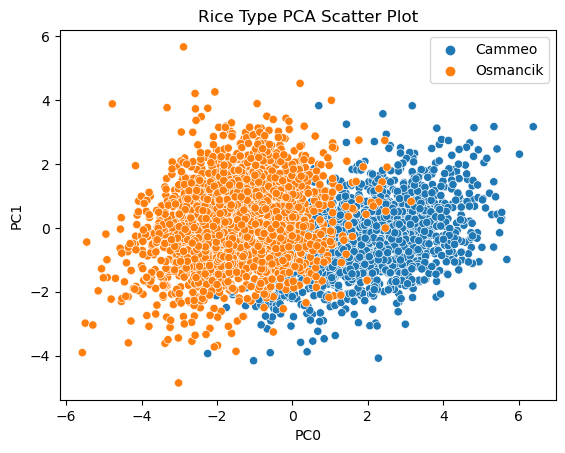

In [7]:
sns.scatterplot(pc0, pc1, hue = np.array(data.iloc[:,7]))
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Rice Type PCA Scatter Plot')
plt.show()

Comment on what the graph suggests about the effeciveness of using k-nearest neighbors on this 2-dimensional reduction of the data to predict the type of rice. **(4 points)**

Two distinct clusters can be seen.  
However, there is no clear boundary or separation between the two clusters.  
The k-nearest neighbors method should be able to classify data in the approximate regions of (-6, -2) and (1, 6).  
It might not be as effective when it comes to classifying data points in (-2, 1) as there is overlap between clusters there. 

Implement a two-dimensional k-nearest neighbors classifier (in particular, do not use sklearn for k-nearest neighbors here): given a list of (x, y; class) data, store this data in a quad-tree  **(14 points)**

Given a new (x, y) point and a value of k (the number of nearest neighbors to examine), it should be able to identify the most common class within those k nearest neighbors.**(14 points)**

In [8]:
class QuadTree:
    def __init__(self, data, bounding_box=None, max_leaf_data=3):
        if bounding_box is None:
            xs, ys, conditions = zip(*data)
            self.xlo = min(xs)
            self.ylo = min(ys)
            self.xhi = max(xs)
            self.yhi = max(ys)
        else:
            self.xlo = bounding_box['xlo']
            self.xhi = bounding_box['xhi']
            self.ylo = bounding_box['ylo']
            self.yhi = bounding_box['yhi']
            
        if len(data) <= max_leaf_data:
            self._data = data
            self.children = []
        else:
            self._data = None
            self.children = []
            xsplit = (self.xlo + self.xhi) / 2
            ysplit = (self.ylo + self.yhi) / 2
            bbox = [
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': ysplit, 'yhi': self.yhi},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': ysplit, 'yhi': self.yhi}
            ]
            self.children = [
                QuadTree(get_data_in_range(data, my_bbox), my_bbox, max_leaf_data)
                for my_bbox in bbox
            ]
    
    
    def get_descendant_count(self):
        if not self.children:
            return len(self._data)
        else:
            return sum(child.get_descendant_count() for child in self.children)
    
    
    def contains(self, x, y):    
        #I think this (xlo and ylo boundaries used) might help with the boundary issue but I have not verified
        #the code works beautifully and I ran out of time to check properly
        if( (self.xlo <= x) and (x < self.xhi) and (self.ylo <= y) and (y < self.yhi) ): 
            return True
        return False
    
    
    def within_distance(self, d, x, y):
        #Cheatsheet Case 1
        if(self.contains(x, y)):
            return True
        
        #Cheatsheet Case 2 
        if(self.xlo <= x <= self.xhi and (y < self.ylo or y > self.yhi) ):
            if(abs(y - self.ylo) < d or abs(y - self.yhi) < d): 
                return True
        
        #Cheatsheet Case 3
        if(self.ylo <= y <= self.yhi and (x < self.xlo or x > self.xhi)):
            if(abs(x - self.xlo) < d or abs(x - self.xhi) < d): 
                return True
        
        #Cheatsheet Case 4
        if min(math.dist([x, y], [self.xlo, self.ylo]),
               math.dist([x, y], [self.xlo, self.yhi]),
               math.dist([x, y], [self.xhi, self.yhi]),
               math.dist([x, y], [self.xhi, self.ylo])) < d:
            return True
        
        return False
    
        
    def leaves_within_distance(self, d, x, y):
        result = []
        
        if not self.children:
            if(self.within_distance(d, x, y) and self._data):
                return self._data
            else:
                return None 
            
        for child in self.children: 
            temp = child.leaves_within_distance(d,x,y)
            if temp: #Drops None return cases 
                for item in temp:
                    result.append(item)
            
        return result
    
    
    def quadtree_diag(self):
        return math.dist( [self.xhi, self.yhi], [self.xlo, self.ylo] )
    
    
    def __repr__(self):
        return f'<QuadTree xlo={self.xlo} ylo={self.ylo} xhi={self.xhi} yhi={self.yhi} #desc={self.get_descendant_count()}>'


In [9]:
def get_data_in_range(data, bbox):
    result = []
    for x, y, condition in data:
        if bbox['xlo'] <= x <= bbox['xhi'] and bbox['ylo'] <= y <= bbox['yhi']:
            result.append([x, y, condition])
    return result


def small_containing_quadtree(quad_in, k, x, y):
    parent = quad_in
    current_quad = quad_in
    
    while (current_quad.get_descendant_count() > k): 
        for child in current_quad.children:
            #print(child)
            if child.contains(x,y):
                parent = current_quad
                current_quad = child

    if current_quad.get_descendant_count() < k: 
        return parent

    return current_quad

In [10]:
def get_fake_data(N=1_000):
    data = []
    for _ in range(N):
        data.append([
            random.random(), 
            random.random(), 
            random.choice(["healthy", "sick"])])
    return data

In [11]:
def knn_quad(quad_in, k, x, y):

    smallest_quad = small_containing_quadtree(quad_in, k, x, y)

    radius = smallest_quad.quadtree_diag()

    first_radius = radius
    
    radius_points = pd.DataFrame( quad_in.leaves_within_distance(radius, x, y) )
    
    #To ensure capture of atleast k points, rarely used 
    while len(radius_points) < k:
        radius = radius*2
        radius_points = pd.DataFrame( quad_in.leaves_within_distance(radius, x, y) )

    radius_points['distance'] = np.sqrt( np.square(radius_points[0] - x) + np.square(radius_points[1] - y))

    out_table = radius_points.sort_values(by=['distance']).reset_index(drop=True).iloc[0:20,:]
    
    result = mode(out_table[2]) #Picks most common tag
    #print(result)
    return out_table, result
 

Testing out the quad tree knn implementation.

In [12]:
fake_data = get_fake_data()
#fake_data

In [13]:
x = 0.5
y = 0.5
k = 20
quad_in = QuadTree(fake_data)

In [14]:
table, tag = knn_quad(quad_in, k, x, y)
print(tag)
table

sick


,0,1,2,distance
0,0.521285,0.519752,healthy,0.029038
1,0.478134,0.524390,sick,0.032757
2,0.465740,0.502601,healthy,0.034359
3,0.538338,0.510178,sick,0.039666
4,0.527561,0.469578,sick,0.041050
5,0.479519,0.460662,sick,0.044350
6,0.544418,0.513268,healthy,0.046358
7,0.460375,0.474059,healthy,0.047361
8,0.463632,0.537944,sick,0.052559
9,0.553843,0.492209,healthy,0.054404


In [15]:
fake_data_test = pd.DataFrame(fake_data)

fake_data_test['distance'] = np.sqrt( np.square(fake_data_test[0] - x) + np.square(fake_data_test[1] - y))
fake_data_test = fake_data_test.sort_values(by=['distance']).reset_index(drop=True).iloc[0:20,:]

print(mode(fake_data_test[2]))
fake_data_test

sick


,0,1,2,distance
0,0.521285,0.519752,healthy,0.029038
1,0.478134,0.524390,sick,0.032757
2,0.465740,0.502601,healthy,0.034359
3,0.538338,0.510178,sick,0.039666
4,0.527561,0.469578,sick,0.041050
5,0.479519,0.460662,sick,0.044350
6,0.544418,0.513268,healthy,0.046358
7,0.460375,0.474059,healthy,0.047361
8,0.463632,0.537944,sick,0.052559
9,0.553843,0.492209,healthy,0.054404


As seen above, both the manual and quad tree-knn returned the same predicion label and 20 closest neighbours

Using a reasonable train-test split with your k-nearest neighbors implementation, give the confusion matrix for predicting the type of rice with k=1. **(4 points)** Repeat for k=5. **(4 points)**

In [16]:
working_data = data.sample(frac=1, random_state=42).reset_index(drop=True) #shuffle data because of incoming Class sorting
working_data

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,12442,459.535004,187.508850,87.187302,0.885323,12941,0.587580,Cammeo
1,12408,437.014008,179.741165,88.829605,0.869343,12598,0.636928,Osmancik
2,12867,449.079987,181.700562,91.341064,0.864460,13152,0.649062,Osmancik
3,13090,472.945007,202.601578,83.230179,0.911722,13331,0.775290,Cammeo
4,10359,409.510986,173.337967,76.875809,0.896273,10510,0.573588,Osmancik
...,...,...,...,...,...,...,...,...
3805,16625,535.989014,229.793594,93.089622,0.914272,16951,0.654141,Cammeo
3806,13901,478.848999,200.441910,89.341988,0.895170,14232,0.568548,Cammeo
3807,16291,523.192993,223.252335,93.604156,0.907859,16595,0.581157,Cammeo
3808,10847,417.924011,170.366791,82.473007,0.875018,11107,0.746319,Osmancik


In [17]:
train_data = working_data[:int((len(working_data)+1)*.85)] #85% train
test_data = working_data[int((len(working_data)+1)*.85):].reset_index(drop=True) #15% test 

print(len(train_data), len(test_data))
train_data

3239 571


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,12442,459.535004,187.508850,87.187302,0.885323,12941,0.587580,Cammeo
1,12408,437.014008,179.741165,88.829605,0.869343,12598,0.636928,Osmancik
2,12867,449.079987,181.700562,91.341064,0.864460,13152,0.649062,Osmancik
3,13090,472.945007,202.601578,83.230179,0.911722,13331,0.775290,Cammeo
4,10359,409.510986,173.337967,76.875809,0.896273,10510,0.573588,Osmancik
...,...,...,...,...,...,...,...,...
3234,12312,447.717010,178.960739,88.517525,0.869109,12593,0.618321,Osmancik
3235,15568,519.455994,222.228088,90.817528,0.912683,15984,0.782705,Cammeo
3236,11183,414.348999,170.649384,83.881950,0.870852,11321,0.616993,Osmancik
3237,14693,484.562988,199.619995,94.807610,0.880018,15034,0.609163,Cammeo


In [18]:
test_data

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,12339,435.937012,173.027420,92.289864,0.845874,12646,0.737493,Osmancik
1,10286,418.289001,175.148590,75.853813,0.901354,10548,0.641592,Osmancik
2,12767,463.842010,196.193039,83.973564,0.903772,13104,0.606220,Cammeo
3,12016,443.222992,189.281067,81.122215,0.903503,12186,0.746567,Osmancik
4,15080,500.006012,209.589279,92.796661,0.896643,15614,0.732323,Cammeo
...,...,...,...,...,...,...,...,...
566,16625,535.989014,229.793594,93.089622,0.914272,16951,0.654141,Cammeo
567,13901,478.848999,200.441910,89.341988,0.895170,14232,0.568548,Cammeo
568,16291,523.192993,223.252335,93.604156,0.907859,16595,0.581157,Cammeo
569,10847,417.924011,170.366791,82.473007,0.875018,11107,0.746319,Osmancik


In [19]:
train_data_raw = train_data.iloc[:,0:7]
test_data_raw = test_data.iloc[:,0:7]
  
scaler = StandardScaler()
st_train_data = scaler.fit_transform( train_data_raw )
st_test_data = scaler.transform( test_data_raw )

pca = decomposition.PCA(n_components=2)
train_data_reduced = pca.fit_transform( st_train_data )
test_data_reduced = pca.transform( st_test_data )

In [20]:
train_data_in = []
count = 0

for item in train_data_reduced:
    train_data_in.append([ item[0], item[1], train_data['Class'][count] ])  
    count = count + 1
    
#train_data_in

In [21]:
test_data_in = []
count = 0

for item in test_data_reduced:
    test_data_in.append([ item[0], item[1], test_data['Class'][count] ])  
    count = count + 1
    
#test_data_in

In [22]:
k = 1
k1_results = []
count = 0
quad_in = QuadTree(train_data_in, max_leaf_data = 1)

for item in test_data_in:
    #print(count)
    count = count + 1
    x = item[0]
    y = item[1]
    table, tag = knn_quad(quad_in, k, x, y)
    
    k1_results.append(tag)

In [23]:
k = 5
k5_results = []
count = 0
quad_in = QuadTree(train_data_in, max_leaf_data = 1)

for item in test_data_in:

    x = item[0]
    y = item[1]
    table, tag = knn_quad(quad_in, k, x, y)
    
    k5_results.append(tag)

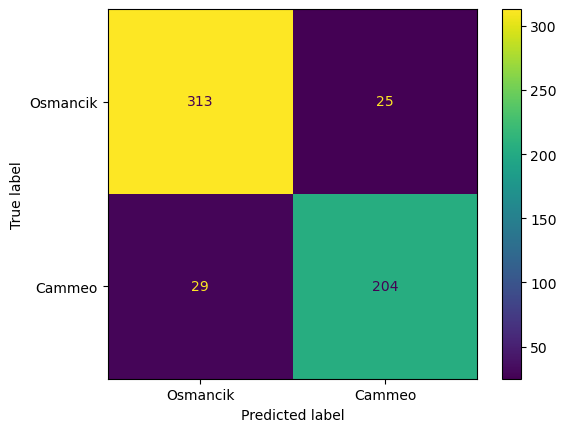

In [24]:
confusion_matrix_1 = confusion_matrix(test_data['Class'], k1_results,  labels=test_data['Class'].unique())
disp_1 = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_1,  display_labels = test_data['Class'].unique())
disp_1.plot()
plt.show()

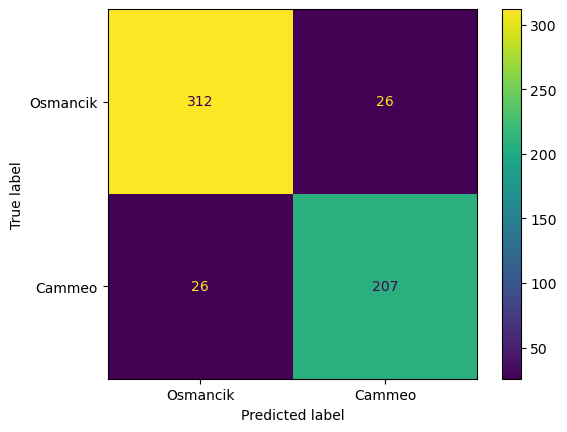

In [26]:
confusion_matrix_5 = confusion_matrix(test_data['Class'], k5_results,  labels=test_data['Class'].unique())
disp_5 = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_5,  display_labels = test_data['Class'].unique())
disp_5.plot()
plt.show()

Provide a brief interpretation of what the confusion matrix results mean. **(4 points)**

This confusion matrix provides information about how many labels were predicted correctly and vice versa.  
Precision checks for how many values predicted are actually what they are - Precision = TP/(TP+FP).   
Recall checks for how many true values the model was able to choose correctly from all true values present - Recall = TP/ (TP + FN).  
   
    
For k = 1:  
313 'Osmancik' labels were actually 'Osmancik' and 204 'Cammeo' were actually 'Cammeo'.  
Precision for 'Osmancik' = 313/(313+29) = 0.915 and Precision for 'Cammeo' = 204/(204 + 25) = 0.890.    
Recall for 'Osmancik' = 313/(313+25) = 0.926 and Precision for 'Cammeo' = 204/(204 + 29) = 0.875.  
  
For k = 5:  
312 'Osmancik' labels were actually 'Osmancik' and 207 'Cammeo' were actually 'Cammeo'.  
Precision for 'Osmancik' = 312/(312+26) = 0.923 and Precision for 'Cammeo' = 207/(207 + 26) = 0.888.  
Recall for 'Osmancik' = 312/(312+26) = 0.923 and Precision for 'Cammeo' = 2047/(207 + 26) = 0.888.  